In [72]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import kurtosis
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sktime.utils.plotting import plot_series

### Задание 1
Прочитать файл 'G2.csv' и 'test.csv'

In [3]:
G2 = pd.read_csv(r"C:\Users\user\Interviews\Тестовое задание CityAir\Задание\G2.csv")
test = pd.read_csv(r"C:\Users\user\Interviews\Тестовое задание CityAir\Задание\test.csv")

In [4]:
G2.head(5)

,date,SO2op1,SO2op2,T,SO2,NO2
0,2022-06-22 09:06:24,389.807,345.705,20.844,448.0,0.0
1,2022-06-22 09:06:54,390.261,345.983,20.875,448.0,0.0
2,2022-06-22 09:07:24,390.261,345.983,20.844,448.0,0.0
3,2022-06-22 09:07:54,389.708,345.844,20.875,448.0,0.0
4,2022-06-22 09:08:24,389.708,345.844,20.875,448.0,0.0


In [5]:
test.head(5)

,date,SO2op1,SO2op2,T,NO2
0,2022-09-12 08:00:00,348.10,344.89,9.845,43.446494
1,2022-09-12 08:05:00,348.20,344.58,9.845,45.494829
2,2022-09-12 08:10:00,348.06,344.53,9.910,45.498952
3,2022-09-12 08:15:00,348.06,344.61,9.970,42.848022
4,2022-09-12 08:20:00,348.30,344.83,10.030,42.880397


### Задание 2 
Предложить модель, которая осуществляет следующую зависимость: 

$$
S02 = f(SO2op1, SO2op2, T, NO2)
$$

#### Поработаем с данными

##### Типы данных

In [6]:
# Посмотрим на типы данных
G2.dtypes 
# Как видим данные имеют тип object, переведем в datetime
# Также проверим действительно ли нам нужны тип переменных float. Есть вероятность, что можно обойтись обычными int 
# (Это сэкономит нам в памяти)

date       object
SO2op1    float64
SO2op2    float64
T         float64
SO2       float64
NO2       float64
dtype: object

In [104]:
# %%writefile convert_time.py # для сохранения и дальнейшего использования
def convert_timestamp(data: pd.Series,column: str, format_:str = '%Y-%m-%d %H:%M:%S', ) -> datetime:
    timestamp = data[column]
    timestamp = pd.to_datetime(timestamp, format = format_)
    return timestamp

In [103]:
G2['date'] = convert_timestamp(G2, 'date')

In [105]:
# Проверка
assert (G2['SO2'] == G2['SO2'].astype('int')).sum()
assert (G2['NO2'] == G2['NO2'].astype('int')).sum() 
# Перекодируем
G2['NO2'] = G2['NO2'].astype('int')
G2['SO2'] = G2['SO2'].astype('int')

In [106]:
G2.dtypes
# все круто

date      datetime64[ns]
SO2op1           float64
SO2op2           float64
T                float64
SO2                int32
NO2                int32
logSO2           float64
hour               int64
minute             int64
second             int64
dtype: object

###### Описательные статистики и работа с нормальностью

In [11]:
# Посмотрим описательные статистики
G2.describe()

,SO2op1,SO2op2,T,SO2,NO2
count,156.000000,156.000000,156.000000,156.000000,156.000000
mean,324.248212,345.540891,20.936311,89.025641,334.769231
std,57.052503,0.351442,0.136996,158.247742,438.963381
min,234.286000,344.685000,20.781500,0.000000,0.000000
25%,284.888000,345.245750,20.844000,0.000000,0.000000
50%,353.593000,345.592500,20.875000,0.000000,0.000000
75%,376.545750,345.815000,21.125000,224.000000,544.000000
max,390.261000,346.267000,21.187500,448.000000,1088.000000


In [13]:
# Посмотрим сколько уникальных значений принимает каждый признак
for feature in G2.columns:
    print(f' Признак {feature} принимает {G2[feature].unique().shape[0]} уникальных значений')

 Признак date принимает 156 уникальных значений
 Признак SO2op1 принимает 80 уникальных значений
 Признак SO2op2 принимает 81 уникальных значений
 Признак T принимает 7 уникальных значений
 Признак SO2 принимает 3 уникальных значений
 Признак NO2 принимает 3 уникальных значений


In [14]:
### Перекодируем нашу переменную (NO2) в категориальные значения
d = {}
for i, value in enumerate(G2['NO2'].unique()):
    d[value] = i
G2['NO2'].replace(d, inplace=True)

In [15]:
# Посмотрим эксцесс
kurtosis = pd.DataFrame(kurtosis(G2.drop('date', axis=1), axis=0, bias=True), columns = ['Эксцесс'])\
.set_index(G2.drop('date', axis=1).columns)
kurtosis
# как мы видим, данные не имеют нормального распределения

,Эксцесс
SO2op1,-1.351088
SO2op2,-0.823911
T,-0.826403
SO2,0.588451
NO2,-0.985797


In [16]:
# Проведем теста Шапиро-Уилка: H0 - нормальное распределение, H1 - ненормальное
data = G2.drop('date', axis=1).copy()
α = 0.05
for column in data.columns:
    test_shapiro = stats.shapiro(data[column])
    if test_shapiro[0] > α:
        print(f'По статистике Шапиро-Уилка для признака "{column}" наблюдается ненормальное распределение ')
    else:
        print(f'По статистике Шапиро-Уилка для признака "{column}" наблюдается нормальное распределение ')

По статистике Шапиро-Уилка для признака "SO2op1" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "SO2op2" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "T" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "SO2" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "NO2" наблюдается ненормальное распределение 


Видеть для признаков нормальное распределение необязательно, но для таргета - желательно, поэтому создадим признак логарифм таргета


In [18]:
G2['logSO2'] = np.log1p(G2['SO2'])
# Проверим распределена ли она нормально
print('p-value теста Шапиро-Уилка: ', stats.shapiro(G2['logSO2'])[0])
# К сожалению, опять ненормальное

p-value теста Шапиро-Уилка:  0.5722941160202026


Можно решить эту проблему с помощью преобразований Кокса-Бокса (в python плохая реализация, поэтому оставим это)

###### Пропуски и некорректность в данных

In [19]:
# Посмотрим пропуски в данных
G2.isna().sum()
# Пропусков нет

date      0
SO2op1    0
SO2op2    0
T         0
SO2       0
NO2       0
logSO2    0
dtype: int64

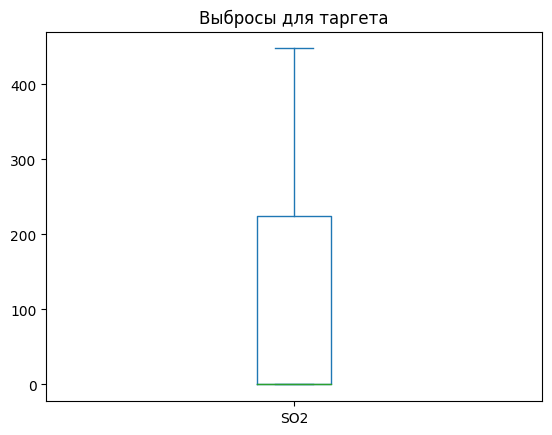

In [20]:
# Посмотрим на выбросы
# Для этого воспользуемся ящиком с усами 
# в реализация подразумевается статистическая проверка
# Посмотрим на таргет
G2['SO2'].plot(kind='box', title='Выбросы для таргета')
plt.show()
# Все нормально

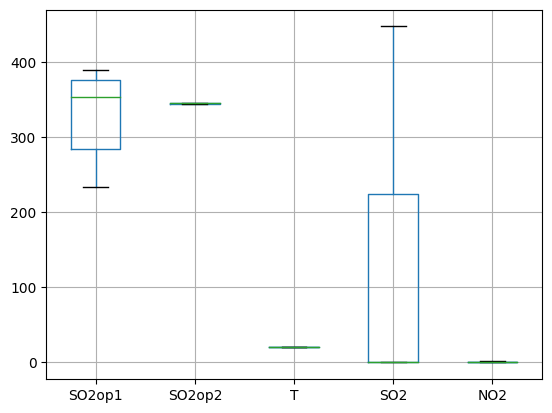

In [21]:
boxplot = data.boxplot(column=list(data.columns))

In [22]:
# Плохо видно, давайте посмотрим на другие графики

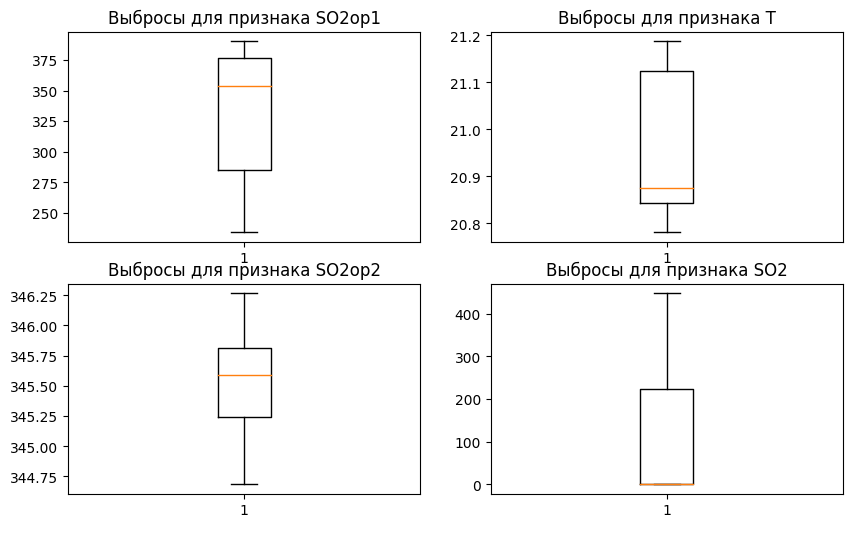

In [23]:
fig, ax = plt.subplots(2,2,  figsize=(10,6))
columns = data.columns
t = 0 
for j in range(2):
    for i in range(2):
        feature = columns[t]
        ax[i, j].boxplot(data[feature])
        ax[i, j].set_title(f'Выбросы для признака {feature}' )
        ax[i, j].set_xlabel(' ')
        t += 1 
# Выбросов не имеется

###### Корелляци

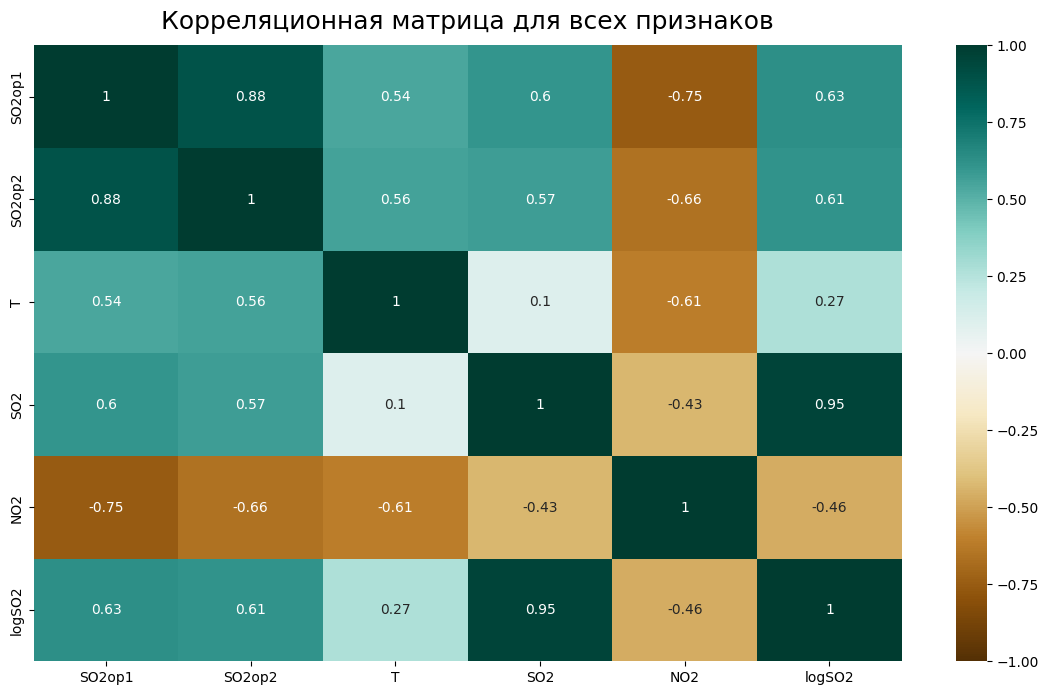

In [24]:
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(G2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляционная матрица для всех признаков', fontdict={'fontsize':18}, pad=12);

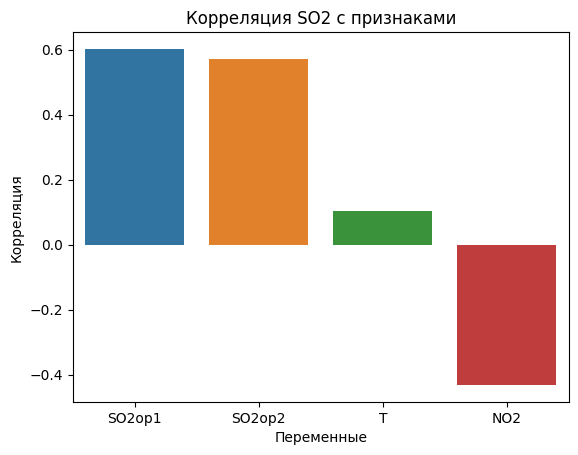

In [25]:
df = G2.corr()[['SO2']].reset_index().drop([3, 5])
sns.barplot(data = df, x = 'index', y = 'SO2')
plt.title('Корреляция SO2 с признаками');
plt.xlabel('Переменные')
plt.ylabel('Корреляция');

###### Графики (EDA)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='SO2'>)

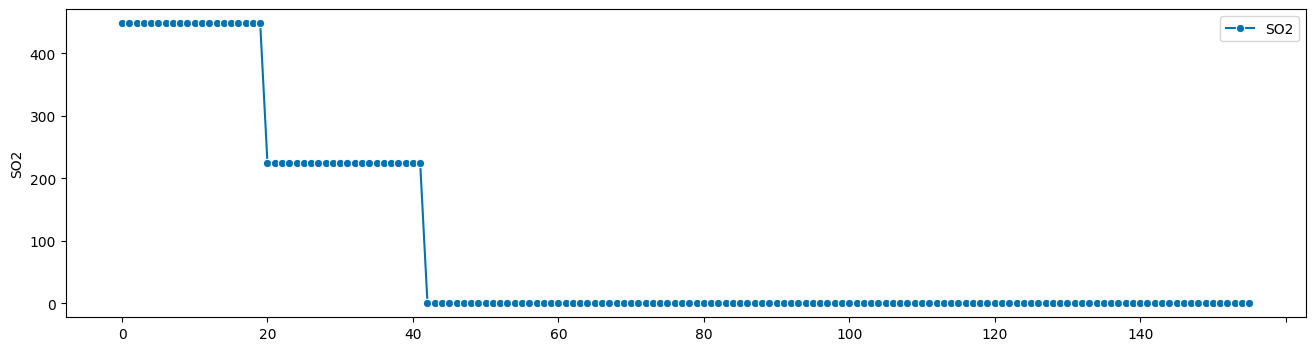

In [26]:
plot_series(G2['SO2'], labels = ['SO2'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='SO2op1'>)

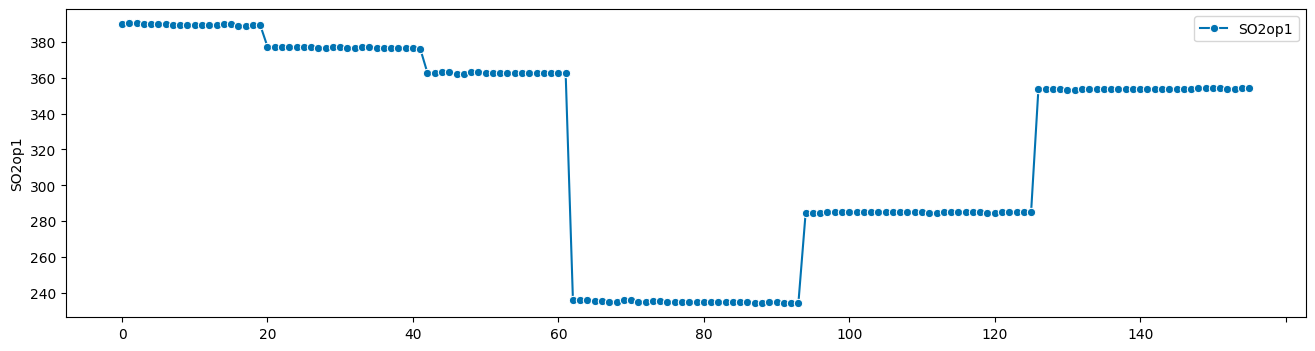

In [27]:
plot_series(G2['SO2op1'], labels = ['SO2op1'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='SO2op2'>)

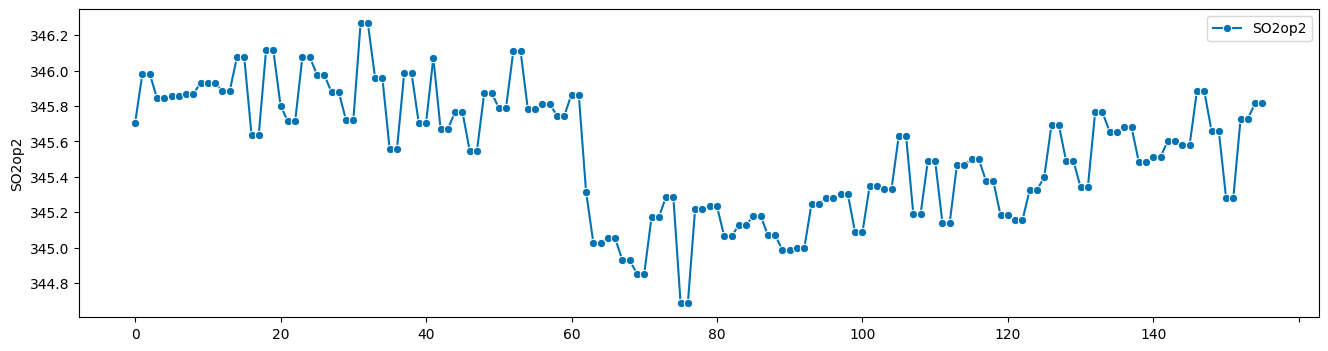

In [28]:
plot_series(G2['SO2op2'], labels=['SO2op2'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='T'>)

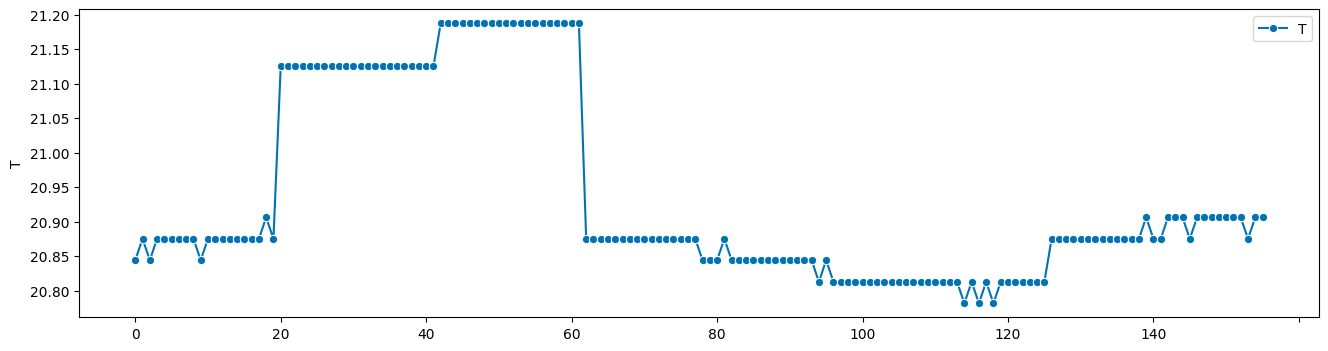

In [29]:
plot_series(G2['T'], labels=['T'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='NO2'>)

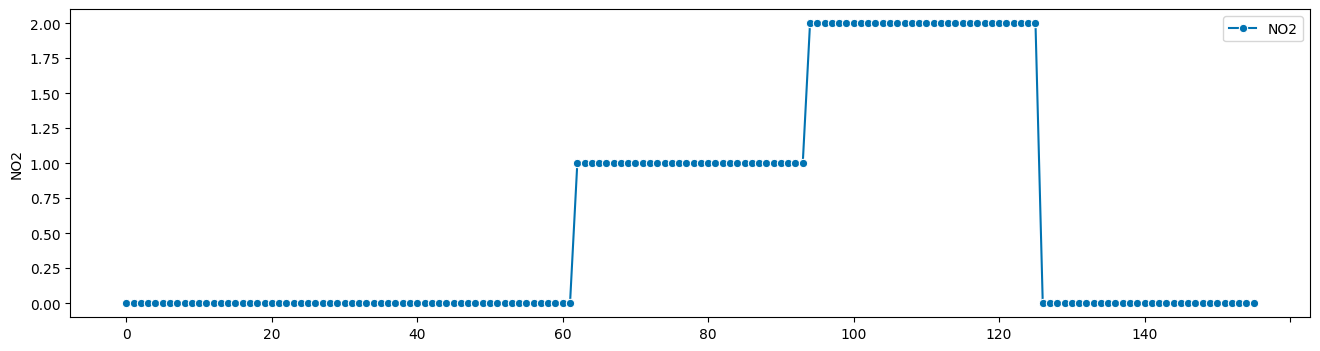

In [30]:
plot_series(G2['NO2'], labels=['NO2'])

###### Feature Engineering

In [31]:
# Попробуем создать новые переменные, сначала поработаем с временем
G2['hour'] = [j.hour for j in G2['date']]
G2['minute'] = [j.minute for j in G2['date']]
G2['second'] = [j.second for j in G2['date']]

In [32]:
# Попробуем взять лаги (1, 2, 3, 5, 7, 10)
# G2['SO2_1'] = G2['SO2'].shift(1)
# G2['SO2_2'] = G2['SO2'].shift(2)
# G2['SO2_3'] = G2['SO2'].shift(3)
# G2['SO2_5'] = G2['SO2'].shift(5)
# G2['SO2_7'] = G2['SO2'].shift(7)
# G2['SO2_10'] = G2['SO2'].shift(10)

Имеем следующие показатели:

* 156 наблюдений -> модель с большим количеством параметров не рассматриваем, так как можем впасть в проблему размерности
* Перевели одну переменную в категориальную переменную (для более точной подачи)
* Пропусков не имеется
* Выбросов не имеется
* Самая сильная корреляция SO2 (далее таргета) имеется с SO2op1 (0.6)
* Самая слабая корреляция с T (0.1)
* Данные распределены не нормально -> создание логарифмированной переменной тоже не помогло, при построение модели это будет учтено
* Судя по графикам, таргет имеет дискретное распределение, поэтому, возможно, лучше всего подойдут либо деревья, либо SVM (так как данные алгоритмы раpбивают наше признаковое пространство, а данные - линейно разделимы)
* Были созданы дополнительные переменные (лаги, переменнные времени)
* Так как нужно будет предсказывать по тесту (где мы имеем только признаковое пространство, не напрямую зависящее от таргета), то мы отказываемся от моделей класса Arima (ARMA, ARIMA, SARIMA, SARIMAX)
* Так как имеется категориальные переменные, то можно попробовать модели Catboost. В алгоритме встроен оптимальный прием работы именно с категориальными переменными (спойлер: отлично справилось и простое дерево решений, поэтому реализацию catboost можно отложить). 

# 3 задание

Рассмотрим метрику **RMSE** (так как она удобна с точки зрения интерпретации)


In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [35]:
# Разделим выборку на тест и трейн
X = G2.drop(['SO2', 'date', 'logSO2'], axis=1)
y = G2[['SO2']]
sc_X = StandardScaler()
X_scaler = sc_X.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_scaler, columns  = X.columns), y, train_size = 0.8, shuffle=True, random_state=123)

###### Линейная регрессия

In [36]:
# Посмотрим на наш бейзлайн, а именно на множественную регрессию
LR = LinearRegression()
model = LR.fit(X_train, y_train)
predict_train_LR = model.predict(X_train)
predict_test_LR = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train_LR) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test_LR) ** 0.5}')

Ошибка на тренировочной выборке: 21.14235413068123
Ошибка на тестовой выборке: 25.229854353810907


In [100]:
# Попробуем кросс-валидацию 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LR, X_scaler, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.array(-scores) ** 0.5) 
# Как мы видим средняя ошибка для линейной регрессии составляет: 32 единицы

32.52044294845662

###### SVM (Support Vector Machine)

In [38]:
SMV = SVR()
model = SMV.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test) ** 0.5}')

Ошибка на тренировочной выборке: 179.44011570399707
Ошибка на тестовой выборке: 152.06294634526816


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
# Попробуем немного подобрать параметры
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
C_range = np.logspace(-1, 1, 3)
gamma_range = np.logspace(-1, 1, 3)
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
scoring = ['MSE']
grid_search = GridSearchCV(estimator=SVR(), 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# Print grid search summary
grid_result

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([ 0.1,  1. , 10. ]),
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'poly']},
             scoring='neg_mean_squared_error')

In [37]:
# Посмотрим на лучшую ошибку
print(f'Средняя ошибка на данных (кросс-валидационная) {-grid_result.best_score_:.4f}')
# Посмотрим на лучшие параметры модели, которая были подобраны с помощью GridSearch
print(f'Лучшие параметры модели {grid_result.best_params_}')

Средняя ошибка на данных (кросс-валидационная) 0.3070
Лучшие параметры модели {'C': 0.1, 'gamma': 10.0, 'kernel': 'poly'}


In [40]:
SMV = SVR(C = 0.1, gamma= 10, kernel='poly')
model = SMV.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test) ** 0.5}')
# 127 -> 0.3070
# кросс-валидация зашита в методе GridSeach, а результаты были приведены выше. 

Ошибка на тренировочной выборке: 185.657807392986
Ошибка на тестовой выборке: 157.60794843559847


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### Decision Tree

In [47]:
# Давайте посмотрим как эту задачу решает дерево
DT = DecisionTreeRegressor()
model = DT.fit(X_train, y_train)
predict_train_DT = model.predict(X_train)
predict_test_DT = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train_DT) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test_DT) ** 0.5}')
# Как мы видим дерево смогло идеально разбить нашу карту признаков, поэтому ошибка 0
# Также оно могло переробучиться, дабы проверить, что это не так, проведем кросс-валидацию

Ошибка на тренировочной выборке: 0.0
Ошибка на тестовой выборке: 0.0


In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(DT, X_scaler, y, cv=10, scoring='neg_mean_squared_error')
np.mean(-scores)
# Как мы видим дерево смогло идеально разбить наше признаковое пространство

0.0

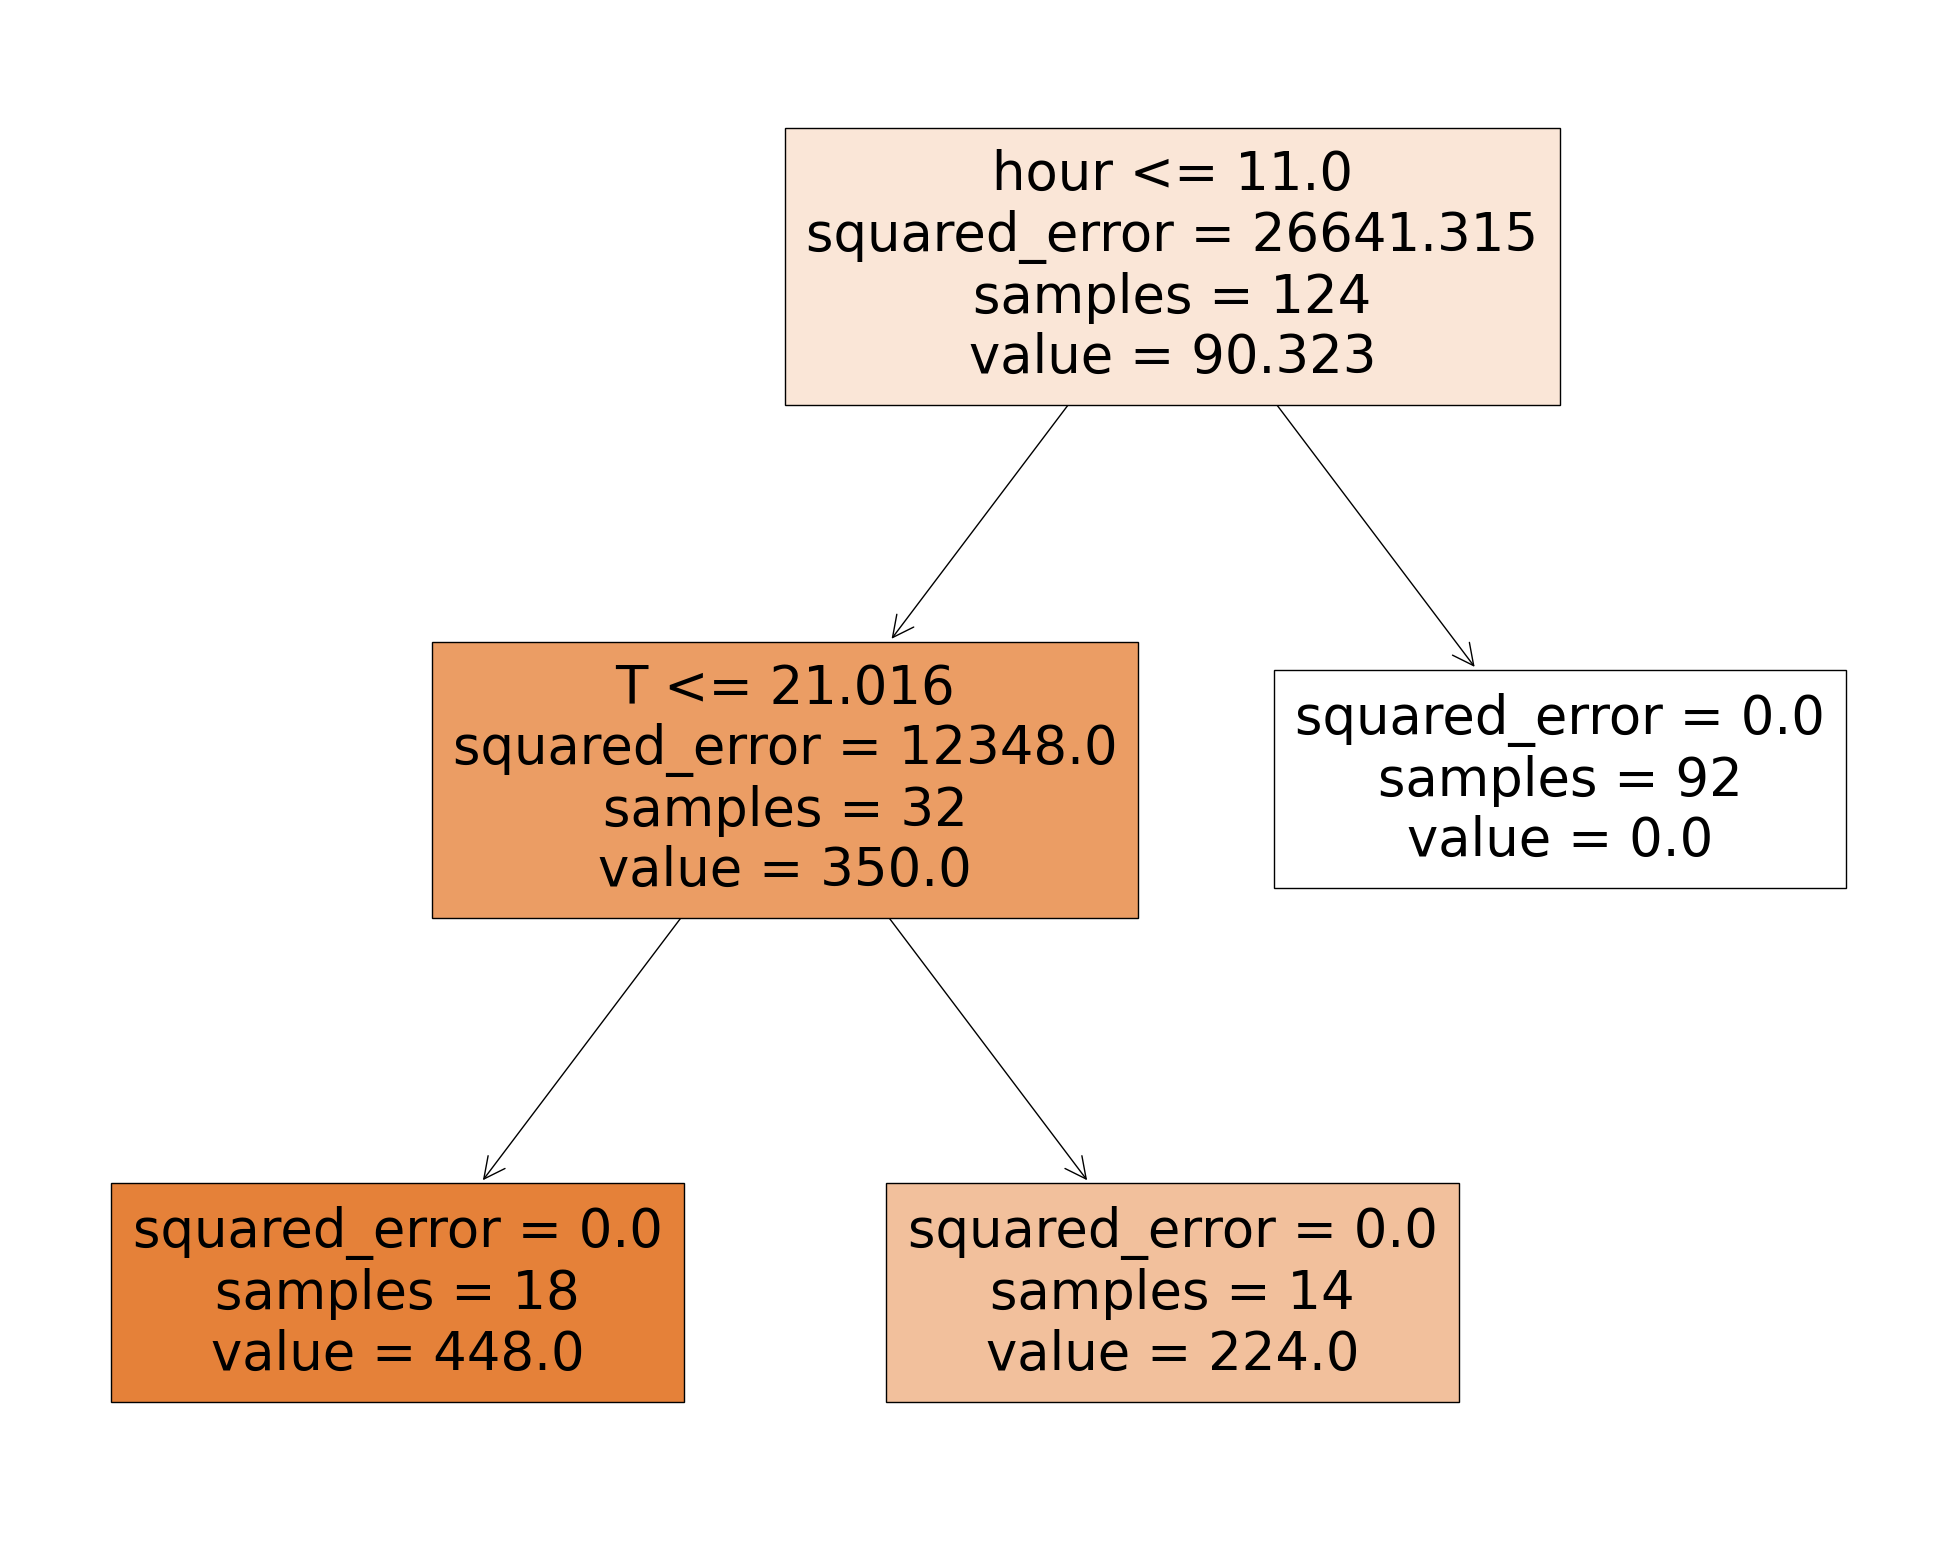

In [96]:
# Давайте посмотрим на то, как же оно разбивает наши признаки
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=True, random_state=123)
DT = DecisionTreeRegressor()
model = DT.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DT, 
                   feature_names=X.columns,  
                   class_names=y.columns,
                   filled=True)
# Как мы видим все зависит от определенного времени, а также от воздействия газа T

# 4 задание

Метрика: 

$$
R M S E=\sqrt{\frac{1}{n} \sum\left(y_i-\hat{y}_i\right)^2}
$$


In [90]:
# Сравнение по метрики RMSE
print(f'Ошибка на тренировочной выборке для линейной регрессии: {mean_squared_error(y_train, predict_train_LR) ** 0.5}')
print(f'Ошибка на тестовой выборке для линейной регрессии: {mean_squared_error(y_test, predict_test_LR) ** 0.5}')

Ошибка на тренировочной выборке для линейной регрессии: 21.14235413068123
Ошибка на тестовой выборке для линейной регресии: 25.229854353810907


In [91]:
print(f'Ошибка на тренировочной выборке для решающего дерева: {mean_squared_error(y_train, predict_train_DT) ** 0.5}')
print(f'Ошибка на тестовой выборке для решающего дерева: {mean_squared_error(y_test, predict_test_DT) ** 0.5}')

Ошибка на тренировочной выборке для решающего дерева: 0.0
Ошибка на тестовой выборке для решающего дерева: 0.0


# 5 задание

In [ ]:
# Графики для ошибок по модели линейной регресии

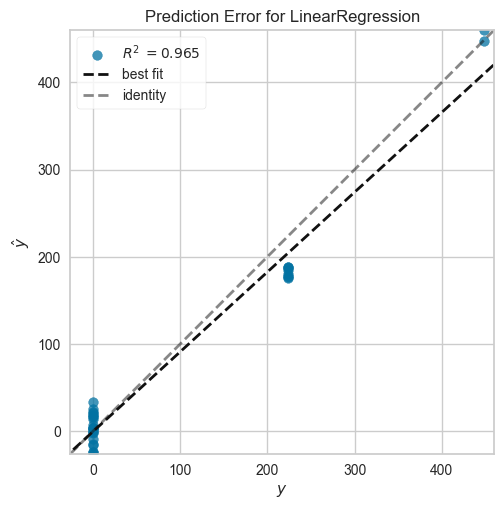

In [109]:
from yellowbrick.regressor import prediction_error
visualizer = prediction_error(LinearRegression(), X_train, y_train['SO2'], X_test, y_test['SO2'])

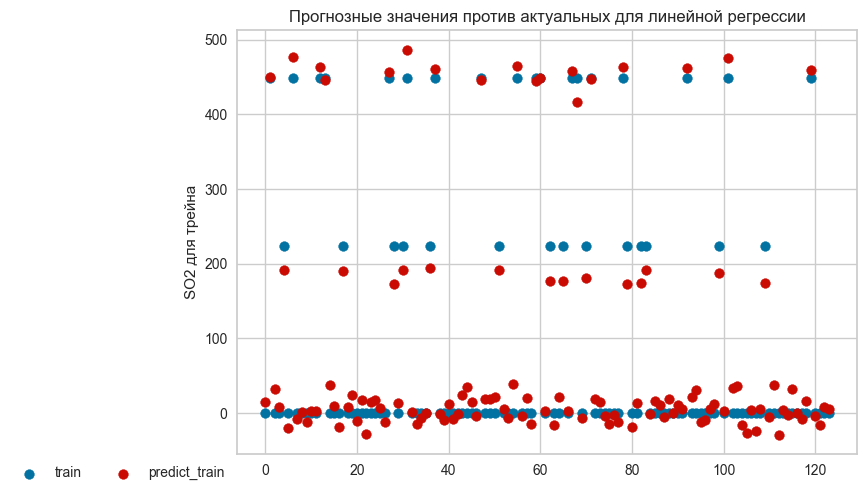

In [126]:
train_plot = plt.scatter(x = np.arange(0, y_train.shape[0]), y = y_train, color = 'b')
pred_plot  = plt.scatter(x = np.arange(0, y_train.shape[0]), y = predict_train_LR, color = 'r')
plt.legend((train_plot, pred_plot),
           ('train', 'predict_train'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для трейна')
plt.title('Прогнозные значения против актуальных для линейной регрессии');

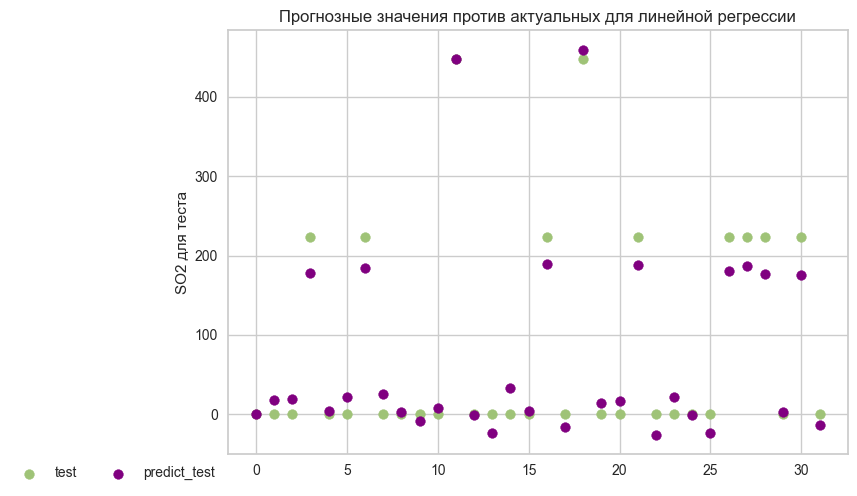

In [132]:
train_plot = plt.scatter(x = np.arange(0, y_test.shape[0]), y = y_test, color = 'g')
pred_plot  = plt.scatter(x = np.arange(0, y_test.shape[0]), y = predict_test_LR, color = 'purple')
plt.legend((train_plot, pred_plot),
           ('test', 'predict_test'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для теста')
plt.title('Прогнозные значения против актуальных для линейной регрессии');

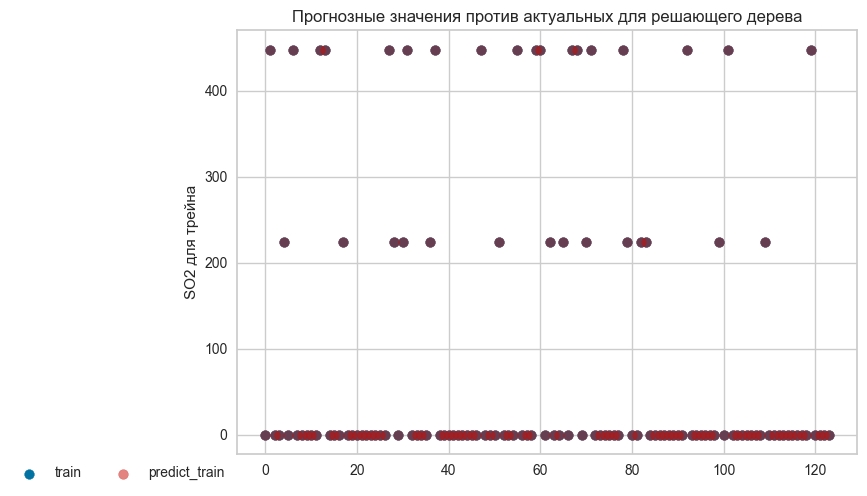

In [143]:
train_plot = plt.scatter(x = np.arange(0, y_train.shape[0]), y = y_train, color = 'b')
pred_plot  = plt.scatter(x = np.arange(0, y_train.shape[0]), y = predict_train_DT, color = 'r', alpha = 0.5)
plt.legend((train_plot, pred_plot),
           ('train', 'predict_train'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для трейна')
plt.title('Прогнозные значения против актуальных для решающего дерева');

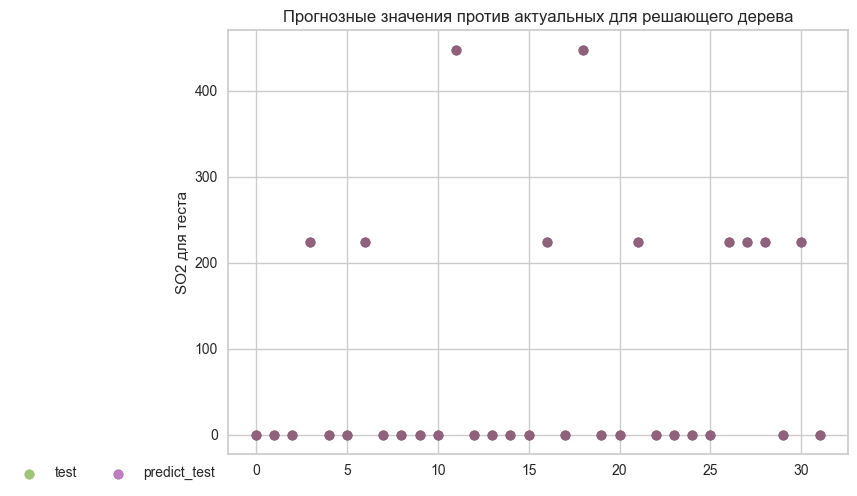

In [145]:
train_plot = plt.scatter(x = np.arange(0, y_test.shape[0]), y = y_test, color = 'g')
pred_plot  = plt.scatter(x = np.arange(0, y_test.shape[0]), y = predict_test_DT, color = 'purple', alpha = 0.5)
plt.legend((train_plot, pred_plot),
           ('test', 'predict_test'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для теста')
plt.title('Прогнозные значения против актуальных для решающего дерева');

# 6 Задание

##### Итерпретируем полученные результаты

Ошибка для нашей модели составила 0 на тестовых данных и 0 на тренировочных. Это не удивительно, так как наши данные оказались линейно разделимы (это можно увидеть на графиках). 

Основным признаком, по которому проходило деление, было время. Видимо, начиная с какого-то момента времени концетрации газа SO2 начинает увеличиваться.

Также на целевую переменную влияние оказывает содержание вещества T. Заметим, что коэффиицент корреляции достаточно низкий (0,1), но при этом наша модель смогла уловить сильную зависимость. Это может быть следствием того факта, что после временного 'очищения', целевая переменная начинает более сильно коррелировать с признаком T.

##### Вывод
1. Необходимо проводить тщательную обработку данных. 
2. Определять модель исходя из распределения целевой переменной.
3. Проводить разведочный анализ данных
4. Для наших данных идеально подходят модели, которые могут работать с линейно разделимым признаковым пространством.
5. SVM и решающее деревья - это те алгоритмы, которые решают эту задачу с ошибкой близкой к 0.
6. Стоит проводить кросс-валидационные методы, иначе (из-за маленького датасета) высока вероятность переобучения.
7. Необходиомо смотреть на коэффииценты полученной модели и проверять их на "разумность".

### Дополнительно

Давайте предскажем тестовую выборку

In [50]:
# Сначала поработаем с данными
test['date'] = convert_timestamp(test, 'date')
test['hour'] = [j.hour for j in test['date']]
test['minute'] = [j.minute for j in test['date']]
test['second'] = [j.second for j in test['date']]

In [54]:
# Далее обучим нашу лучшую модель (DT) на всех  тренировочных данных
DT = DecisionTreeRegressor()
DT.fit(X, y)
predict = DT.predict(test.drop('date', axis=1))

In [ ]:
# Сохраним в csv формат
predict.to_csv('Predict.csv', encoding = 'utf-8')

Оценить погрешности предложенной модели и линейной регрессии

In [73]:
# Пограшеность линейной регресии в целом по выборке
LR = LinearRegression()
predict_LR = LR.fit(X, y).predict(X)
error = y - predict_LR
print('Средняя погрешность для линейной модели:',(np.mean(error ** 2) ** 0.5).item())

Средняя погрешность для линейной модели: 21.766904778603685


In [84]:
# Пограшеность решающего дерева в целом по выборке
DT = DecisionTreeRegressor()
predict_DT= DT.fit(X, y).predict(X)
error = np.array(y.T) - predict_DT
print('Средняя погрешность для линейной модели:',(np.mean(error ** 2) ** 0.5).item())

Средняя погрешность для линейной модели: 0.0


Чем отличается предложенная модель от линейной регрессии

Предложенная модель отличается от линейной регресси:
1. Разная спецификация модели. В линейной регресии существует предположение о том, что зависимая переменная зависит от регрессоров линейно. В нашей модели рассматривается также нелинейная связь
2. Разное построение модели. Это вытекает из 1 пункта. Построение линейной регресии основано на решение задачи МНК (минимизации квадратов остатков), в то время как наша модель минимизурует энтропийный критерий (или максимизирует прирост информации)
3. Отсутствие жестких предположений. Линейная модель основа на теореме Гаусса-Маркова, и качество оценок (несмещенность, состоятельонсть, эффективность) зависит от выполнение тех самых предпоссылок. В деревьях таких сильных предположений нет.
4. Разная интерпретируемость. В линейной модели мы можем проинтерпретировать каждый коэффиициент, в то время как в нашей модели, мы можем интерпретировать только значимые коэффииценты.
5. Разная интерполяция данных. Линейная модель может интерполировать данные, даже такие, которые не встречались в тренировочной выборке. В то время как наша модель интерполирует данные относительно тренировочной выборки. Это несколько уменьшает ее функционал и применимость.
6. Разный подход к пропускам. В линейную модель, перед тем как подавать данные, необходимо поработать с пропусками. В то время как для нашей модели, последнего не требуется

Что можно сказать об обучающей и тестовой выборке

In [89]:
G2.describe()

,SO2op1,SO2op2,T,SO2,NO2,logSO2,hour,minute,second
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,324.248212,345.540891,20.936311,89.025641,0.615385,1.546761,15.141026,22.474359,26.807692
std,57.052503,0.351442,0.136996,158.247742,0.806918,2.562812,4.018423,14.284415,17.461521
min,234.286000,344.685000,20.781500,0.000000,0.000000,0.000000,9.000000,0.000000,4.000000
25%,284.888000,345.245750,20.844000,0.000000,0.000000,0.000000,10.000000,9.000000,7.000000
50%,353.593000,345.592500,20.875000,0.000000,0.000000,0.000000,18.000000,17.500000,31.000000
75%,376.545750,345.815000,21.125000,224.000000,1.000000,5.416100,18.000000,37.000000,37.000000
max,390.261000,346.267000,21.187500,448.000000,2.000000,6.107023,19.000000,44.000000,58.000000


In [88]:
test.describe()

,SO2op1,SO2op2,T,NO2,hour,minute,second
count,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.0
mean,349.137315,345.137569,11.457517,47.368465,11.494213,27.494213,0.0
std,0.576363,0.353824,1.884068,12.585284,6.927030,17.278644,0.0
min,347.100000,343.040000,9.000000,14.723622,0.000000,0.000000,0.0
25%,348.780000,344.920000,9.902500,39.500451,5.750000,13.750000,0.0
50%,349.100000,345.160000,11.080000,44.851663,11.000000,27.500000,0.0
75%,349.460000,345.370000,12.352500,52.257360,17.250000,41.250000,0.0
max,352.560000,346.080000,16.030000,87.887305,23.000000,55.000000,0.0


Как мы видим существует определенные дисбаланс: тестовая выбора имеет 864 наблюдения, в то время как тренировочная 156.

Данные для тестовой и тренировочной части взяты из разных временных промежутков. Данный факт должен моделироваться временными признаками, но есть вероятность структурного сдвига. К примеру, в период между тестовыми данными и тренировочными компания А решила нарастить производство, тем самым произошел резкий сплеск газов, что может послужить фактором изменения распределения целевой переменной. Для покрытия такой компоненты, можно использовать новостные данные.

Также некоторые статистики не равны. Допустим, если возьмем среднюю концетрацию газа T, то для тренировочных данных она сосотавляет $20$, а для тестовых $11$, при это дисперсия для двух наборов данных не превышает $1$. Это может говорить о том, что данные взяты из разных распределений.  